## Overview 

This script performs EDA and then preprocesses multiple datasets to train a bidirectional LSTM model which is in turn used to predict the sentiments behind tweets fetched in real time using `tweepy` and classify them as positive negative or neutral.

The model is then integrated with streamlit and deployed as a web-app.

**Checkout the web-app:** [Sententia](https://share.streamlit.io/kritanjalijain/twitter_sentiment_analysis/main/app.py)

## Installing and importing dependencies

To fetch tweets from twitter, we need to install the tweepy library. We will be using this package to pull tweets on which our model will make predictions.

In [1]:
!pip install tweepy

     |████████████████████████████████| 98 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 151 kB 80.3 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 136 kB 60.3 MB/s eta 0:00:01
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: oauthlib
    Found existing installation: oauthlib 3.0.1
    Uninstalling oauthlib-3.0.1:
      Successfully uninstalled oauthlib-3.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda 4.9.2 requires ruamel_yaml>=0.11.14, which is not installed.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Exploratory Data Analysis

### Cleaning and prepping dataset

In [3]:
# Load Tweet dataset
df1 = pd.read_csv('../input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv')
# Output first five rows
df1.head()

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

In [4]:
# Load Tweet dataset
df2 = pd.read_csv('../input/appletwittersentimenttexts/apple-twitter-sentiment-texts.csv')
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
# Output first five rows

df2.head()

clean_text  category
0  Wow. Yall needa step it up @Apple RT @heynyla:...      -1.0
1  What Happened To Apple Inc?   http://t.co/FJEX...       0.0
2  Thank u @apple I can now compile all of the pi...       1.0
3  The oddly uplifting story of the Apple co-foun...       0.0
4  @apple can i exchange my iphone for a differen...       0.0

The `category` column has 3 values:
1. 0 Indicating it is a Neutral Sentiment
2. 1 Indicating a Postive Sentiment
3. -1 Indicating a Negative Sentiment

In [5]:
# Load Tweet dataset
df3 = pd.read_csv('../input/twitterdata/finalSentimentdata2.csv')
df3 = df3.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df3['category'] = df3['category'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy':1.0})
df3 = df3.drop(['Unnamed: 0'], axis=1)
# Output first five rows
df3.head()

category                                         clean_text
0      -1.0  agree the poor in india are treated badly thei...
1       1.0  if only i could have spent the with this cutie...
2       1.0  will nature conservation remain a priority in ...
3      -1.0  coronavirus disappearing in italy show this to...
4      -1.0  uk records lowest daily virus death toll since...

In [6]:
# Load Tweet dataset
df4 = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv')
df4 = df4.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df4 = df4[['category','clean_text']]
# Output first five rows
df4.head()

category                                         clean_text
0       0.0                @VirginAmerica What @dhepburn said.
1       1.0  @VirginAmerica plus you've added commercials t...
2       0.0  @VirginAmerica I didn't today... Must mean I n...
3      -1.0  @VirginAmerica it's really aggressive to blast...
4      -1.0  @VirginAmerica and it's a really big bad thing...

In [7]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [8]:
# Check for missing data
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [9]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [10]:
# dimensionality of the data
df.shape

(182329, 2)

In [11]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head()

clean_text  category
0  when modi promised “minimum government maximum...  Negative
1  talk all the nonsense and continue all the dra...   Neutral
2  what did just say vote for modi  welcome bjp t...  Positive
3  asking his supporters prefix chowkidar their n...  Positive
4  answer who among these the most powerful world...  Positive

## Exploratory Data Analysis

Data Visualisation-

In [12]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

Plotting the distribution of tweet lengths

In [13]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

Plotting the distribution of text length for positive sentiment tweets

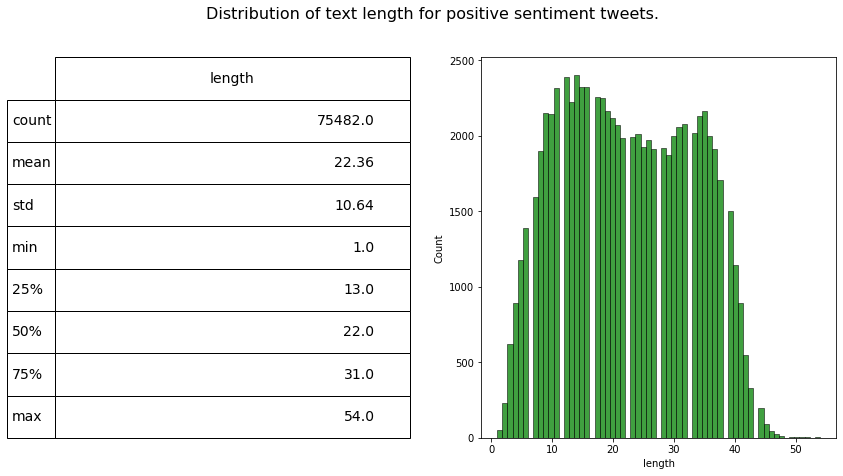

In [14]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

Plotting the Distribution of text length for Negative sentiment tweets.

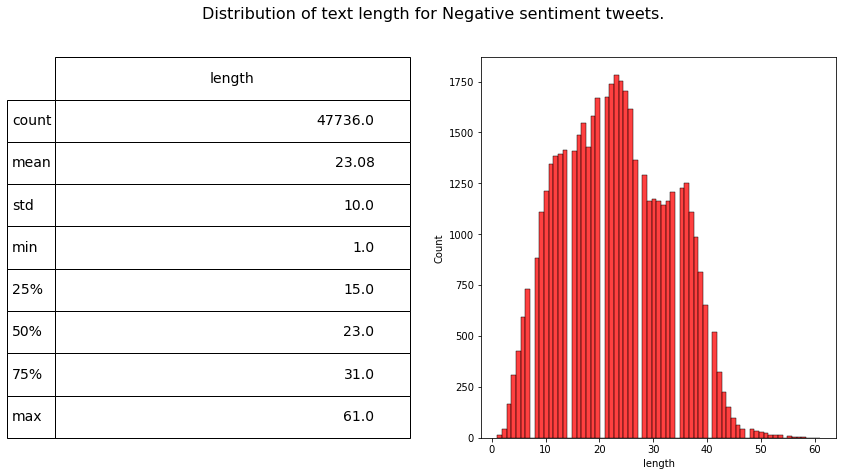

In [15]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

Plotting the Pie chart of the percentage of different sentiments of all the tweets

In [16]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [17]:
df.drop(['length'], axis=1, inplace=True)
df.head

<bound method NDFrame.head of                                                clean_text  category
0       when modi promised “minimum government maximum...  Negative
1       talk all the nonsense and continue all the dra...   Neutral
2       what did just say vote for modi  welcome bjp t...  Positive
3       asking his supporters prefix chowkidar their n...  Positive
4       answer who among these the most powerful world...  Positive
...                                                   ...       ...
182335  @AmericanAir thank you we got on a different f...  Positive
182336  @AmericanAir leaving over 20 minutes Late Flig...  Negative
182337  @AmericanAir Please bring American Airlines to...   Neutral
182338  @AmericanAir you have my money, you change my ...  Negative
182339  @AmericanAir we have 8 ppl so we need 2 know h...   Neutral

[182329 rows x 2 columns]>

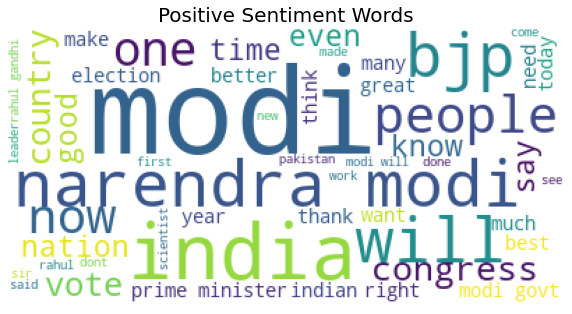

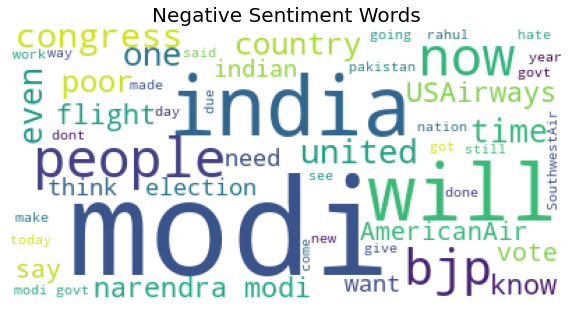

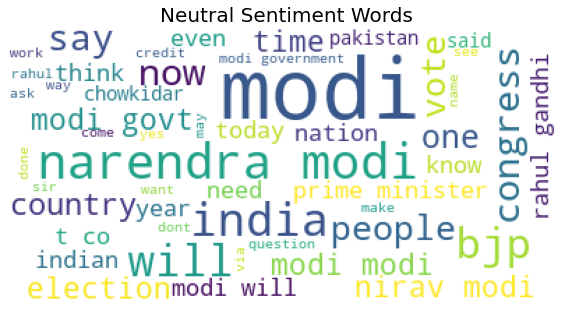

In [18]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 'Positive')
     
# Negative tweet words
wordcount_gen(df, 'Negative')
     
# Neutral tweet words
wordcount_gen(df, 'Neutral')
     


## Data Preprocessing

In [19]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [ ]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [ ]:
print(X[0])
print(Y[0])

### Train and test split

In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### Bag of words (BOW) feature extraction

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [ ]:
#import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
#X_train = pr.normalize(X_train, axis=1)
#X_test  = pr.normalize(X_test, axis=1)

In [ ]:
# print first 200 words/tokens
print(count_vector.get_feature_names()[0:200])

In [ ]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Tokenizing & Padding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

### Saving tokenized data

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Train & Test Split

In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM Using NN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

### Model Accuracy & Loss

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

### Model Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

### Model save and load for the prediction

In [ ]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

In [ ]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['"I hate when I have to call and wake people up'])

In [ ]:
predict_class(['The food was meh'])

In [ ]:
predict_class(['He is a best minister india ever had seen'])

To use the 'tweepy' API, you need to create an account with Twitter Developer. After creating the account, go to 'Get Started' option and navigate to the 'Create an app' option. After you create the app, note down the below required credentials from there.

## Fetching data from twitter

To get started, you’ll need to do the following things:

  * Set up a Twitter account if you don’t have one already.
  * Using your Twitter account, you will need to apply for Developer Access and then create an application that will generate the API credentials that you will use to access Twitter from Python.
  *  Import the `tweepy` package.

### Authorization

After installing and importing `tweepy` package (already done in the beginning),to access the Twitter API, you will need 4 things from the your Twitter App page. These keys are located in your Twitter app settings in the Keys and Access Tokens tab.

    consumer key
    consumer seceret key
    access token key
    access token secret key

Do not share these with anyone else because these values are specific to your app.

In [ ]:
#Getting authorization
consumer_key= 'yourkeyhere'
consumer_secret= 'yourkeyhere'
access_token= 'yourkeyhere'
access_token_secret= 'yourkeyhere'

auth = tw.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

## Search Twitter for Tweets

### 1. Searching for a hashtag from a specified date

Now you are ready to search Twitter for recent tweets! You will use the `.Cursor` method to get an object containing tweets containing the hashtag #wildfires.

To create this query, you will define the:

   * Search term - in this case #WorkFromHome
   * the start date of your search

In [ ]:
# Define the search term and the date_since date as variables
search_words = "#WorkFromHome"
date_since = "2021-06-10"

You can restrict the number of tweets returned by specifying a number in the `.items()` method. `.items(10)` will return 10 of the most recent tweets.

In [ ]:
# Collect tweets
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(10)

# Iterate and print tweets
for tweet in tweets:
    print(tweet.text)
    predict_class([tweet.text]) #predicting sentiment
    print("")

### 2. Searching for a keyword

You can pass the keyword of your interest here and the number of tweets (in this case 10) to be downloaded through the tweepy API.

In [ ]:
for tweet in api.search(q="elonmusk", lang="en", rpp=10):
    print(f"{tweet.user.name}:{tweet.text}")
    predict_class([tweet.text]) #predicting sentiment
    print("")

### 3. Searching for a username

The `user_timeline()` method of the API class in Tweepy module is used to get the most recent statuses posted from the authenticating user or the user specified.

* `screen_name` = user id name of the twitter user
* `count` = no. of tweets to be fetched
* `lang` = language of tweet 
* `tweet_mode = 'extended'` swaps the text index for full_text, and prevents a primary tweet longer than 140 characters from being truncated.


The below query pulls 10 tweets from Twitter user @ of english language and predicts its sentiments.

In [ ]:
posts = api.user_timeline(screen_name="elonmusk", count = 10, lang ="en", tweet_mode="extended")

l=[] 
i=1

for tweet in posts[:10]:
    l.append(tweet.full_text) 
    i=i+1
for j in range (0,9):
    print(l[j])
    predict_class([l[j]])  #predicting sentiment
    print("\n")